In [1]:
import pickle
import numpy as np
from shapely.geometry import LineString 
from l5kit_conflict.analysis.utils import compute_position_based_velocities, three_sigma_smoothing

In [2]:
# first junction
with open('./lyft_avhv_conflict_j1.pkl', 'rb') as file:
    lyft_avhv_conflict_list1 = pickle.load(file)

with open('./lyft_hvhv_conflict_j1.pkl', 'rb') as file:
    lyft_hvhv_conflict_list1 = pickle.load(file)

# second junction
with open('./lyft_avhv_conflict_j2.pkl', 'rb') as file:
    lyft_avhv_conflict_list2 = pickle.load(file)

with open('./lyft_hvhv_conflict_j2.pkl', 'rb') as file:
    lyft_hvhv_conflict_list2 = pickle.load(file)

lyft_conflict_list1 = lyft_avhv_conflict_list1 + lyft_hvhv_conflict_list1 # + lyft_avhv_conflict_list2 + lyft_hvhv_conflict_list2
lyft_conflict_list2 = lyft_avhv_conflict_list2 + lyft_hvhv_conflict_list2

C:\Users\Gavin\AppData\Local\Temp\ipykernel_22652\2357259342.py:3: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  lyft_avhv_conflict_list1 = pickle.load(file)
C:\Users\Gavin\AppData\Local\Temp\ipykernel_22652\2357259342.py:6: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  lyft_hvhv_conflict_list1 = pickle.load(file)
C:\Users\Gavin\AppData\Local\Temp\ipykernel_22652\2357259342.py:10: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  lyft_avhv_conflict_list2 = pickle.load(file)
C:\Users\Gavin\AppData\Local\Temp\ipykernel_22652\2357259342.py:13: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  lyft_hvhv_conflict_list2 = pickle.load(file)


## Junction 2

In [18]:
# %% define the collections of TAs.
HVHV_TAs = []
AVHV_TAs = []
HVAV_TAs = []
HVHV_TAs_merge = []
AVHV_TAs_merge = []
HVAV_TAs_merge = []
HVHV_TAs_cross = []
AVHV_TAs_cross = []
HVAV_TAs_cross = []

print("Calculate the TA distribution")
for index, conflict in enumerate(lyft_conflict_list2):

    first_xyt = np.hstack(
        [conflict.first_trajectory.xy, conflict.first_trajectory.t.reshape((-1,1))])
    second_xyt = np.hstack(
        [conflict.second_trajectory.xy, conflict.second_trajectory.t.reshape((-1,1))])
    
    # extract the trajectory within the study rectangle
    first_xyt = first_xyt[
        (first_xyt[:, 0] <=  -50) &
        (first_xyt[:, 0] >= -200) &
        (first_xyt[:, 1] <= -830) &
        (first_xyt[:, 1] >= -915)
    ]
    second_xyt = second_xyt[
        (second_xyt[:, 0] <= -50) &
        (second_xyt[:, 0] >= -200) &
        (second_xyt[:, 1] <= -830) &
        (second_xyt[:, 1] >= -915)
    ]
  
    # take the first timestamp that two vehicles co-exist
    coexist_start_time = max(first_xyt[0, 2], second_xyt[0, 2])
    first_xyt = first_xyt[
        (conflict.first_time_at_conflict > first_xyt[:, 2]) &
        (first_xyt[:, 2] >= coexist_start_time)
        ]    
    second_xyt = second_xyt[
        (conflict.first_time_at_conflict > second_xyt[:, 2]) &
        (second_xyt[:, 2] >= coexist_start_time)
        ]
    
    # %% discard the samples with short trajectory (unable to calculate position-based speed)
    if first_xyt.shape[0] < 3 or second_xyt.shape[0] < 3:
        continue
    assert first_xyt[0, 2] == second_xyt[0, 2], \
        f"Two vehicles' initial states were not in the same time instant."
    
    
    if first_xyt.shape[0] !=  second_xyt.shape[0]:
        print("Non-equal two trajectories", first_xyt.shape, second_xyt.shape)
        len_traj = min(first_xyt.shape[0], second_xyt.shape[0]) - 2
    else:
        len_traj = first_xyt.shape[0] - 2

    this_traj_TAs = []
    TIME = 0
    for jdx in range(len_traj-TIME):
        # %% calculate the length and speed -> to get TA
        len_first_traj = LineString(first_xyt[jdx:, :2]).length 
        first_speed = three_sigma_smoothing(compute_position_based_velocities(first_xyt[jdx+TIME:jdx+TIME+3, :2]))[0]
        len_second_traj = LineString(second_xyt[jdx:, :2]).length
        second_speed = three_sigma_smoothing(compute_position_based_velocities(second_xyt[jdx+TIME:jdx+TIME+3, :2]))[0]
        TA = len_second_traj / second_speed - len_first_traj / first_speed
       
        if conflict.is_first_AV:
            AVHV_TAs.append(TA)
            if conflict.category == "merge":
                AVHV_TAs_merge.append(TA)
            else:
                AVHV_TAs_cross.append(TA)
        else:
            HVAV_TAs.append(TA)
            if conflict.category == "merge":
                HVAV_TAs_merge.append(TA)
            else:
                HVAV_TAs_cross.append(TA)
        this_traj_TAs.append(TA)

len(HVAV_TAs_cross)

Calculate the TA distribution


C:\Users\Gavin\AppData\Local\Temp\ipykernel_22652\860345885.py:66: RuntimeWarning: invalid value encountered in scalar divide
  TA = len_second_traj / second_speed - len_first_traj / first_speed
C:\Users\Gavin\AppData\Local\Temp\ipykernel_22652\860345885.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  TA = len_second_traj / second_speed - len_first_traj / first_speed


Non-equal two trajectories (56, 3) (98, 3)
Non-equal two trajectories (10, 3) (9, 3)
Non-equal two trajectories (16, 3) (15, 3)


12848

In [4]:
AVHV_TAs = np.array(AVHV_TAs)
HVAV_TAs = np.array(HVAV_TAs)
AVHV_TAs_merge = np.array(AVHV_TAs_merge)
HVAV_TAs_merge = np.array(HVAV_TAs_merge)
AVHV_TAs_cross = np.array(AVHV_TAs_cross)
HVAV_TAs_cross = np.array(HVAV_TAs_cross)

TA_MIN = -20
TA_MAX = 20

print(AVHV_TAs.shape)

AVHV_TAs = AVHV_TAs[
    (AVHV_TAs >= TA_MIN) &
    (AVHV_TAs <= TA_MAX)
]

print(AVHV_TAs.shape)

HVAV_TAs = HVAV_TAs[
    (HVAV_TAs >= TA_MIN) &
    (HVAV_TAs <= TA_MAX)
]

AVHV_TAs_merge2 = AVHV_TAs_merge[
    (AVHV_TAs_merge >= TA_MIN) &
    (AVHV_TAs_merge <= TA_MAX)
]
HVAV_TAs_merge2 = HVAV_TAs_merge[
    (HVAV_TAs_merge >= TA_MIN) &
    (HVAV_TAs_merge <= TA_MAX)
]

AVHV_TAs_cross2 = AVHV_TAs_cross[
    (AVHV_TAs_cross >= TA_MIN) &
    (AVHV_TAs_cross <= TA_MAX)
]
HVAV_TAs_cross2 = HVAV_TAs_cross[
    (HVAV_TAs_cross >= TA_MIN) &
    (HVAV_TAs_cross <= TA_MAX)
]

(4215,)
(2942,)


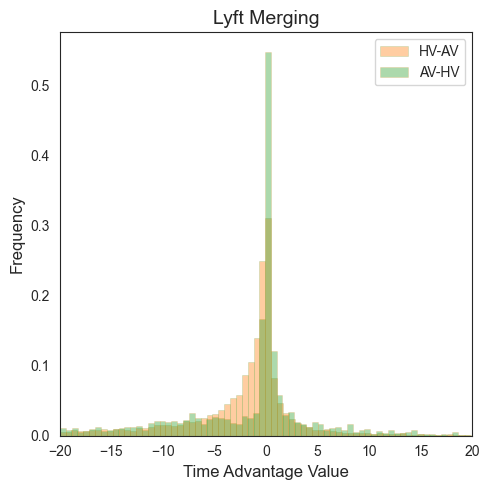

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns


TA_MIN = -20
TA_MAX = 20

# Define the custom color palette
palette = {
    "HV-HV": '#257ab6',  # Blue
    "AV-HV": '#31a231',  # Green
    "HV-AV": '#ff8214',  # Orange
}

# Set the Seaborn style without grid
sns.set_style("white")  # Remove grid by using 'white' style

# Create the plot with a square aspect ratio
fig, ax = plt.subplots(figsize=(5, 5))  # Make the figure square

# Use Seaborn to plot the histograms with custom colors
sns.histplot(
    HVAV_TAs_merge2,
    bins=70,
    stat="density",  # Use 'density' for frequency normalization
    kde=False,       # Add kernel density estimate if needed
    color=palette["HV-AV"],  # Use the custom color from the palette
    alpha=0.4,
    label='HV-AV',
    edgecolor=(49/255, 162/255, 49/255, 0.3)  # Match edge color with the fill color with transparency
)

sns.histplot(
    AVHV_TAs_merge2,
    bins=70,
    stat="density",  # Use 'density' for frequency normalization
    kde=False,       # Add kernel density estimate if needed
    color=palette["AV-HV"],  # Use another custom color from the palette
    alpha=0.4,
    label='AV-HV',
    edgecolor=(255/255, 130/255, 20/255, 0.3)  # Match edge color with the fill color with transparency
)

# Customize the plot
ax.set_title("Lyft Merging", fontsize=14)
ax.set_xlabel("Time Advantage Value", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_xlim([TA_MIN, TA_MAX])

# Add a legend
ax.legend(loc='upper right', fontsize=10)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

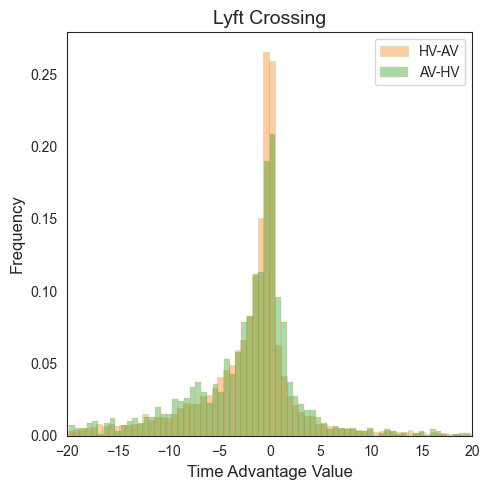

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

TA_MIN = -20
TA_MAX = 20

# Define the custom color palette
palette = {
    "HV-HV": '#257ab6',  # Blue
    "AV-HV": '#31a231',  # Green
    "HV-AV": '#ff8214',  # Orange
}

# Set the Seaborn style without grid
sns.set_style("white")  # Remove grid by using 'white' style

# Create the plot with a square aspect ratio
fig, ax = plt.subplots(figsize=(5, 5))  # Make the figure square

# Use Seaborn to plot the histograms with custom colors
sns.histplot(
    HVAV_TAs_cross2,
    bins=70,
    stat="density",  # Use 'density' for frequency normalization
    kde=False,       # Add kernel density estimate if needed
    color=palette["HV-AV"],  # Use the custom color from the palette
    alpha=0.4,
    label='HV-AV',
    edgecolor=(49/255, 162/255, 49/255, 0.3)  # Match edge color with the fill color with transparency
)

sns.histplot(
    AVHV_TAs_cross2,
    bins=70,
    stat="density",  # Use 'density' for frequency normalization
    kde=False,       # Add kernel density estimate if needed
    color=palette["AV-HV"],  # Use another custom color from the palette
    alpha=0.4,
    label='AV-HV',
    edgecolor=(255/255, 130/255, 20/255, 0.3)  # Match edge color with the fill color with transparency
)

# Customize the plot
ax.set_title("Lyft Crossing", fontsize=14)
ax.set_xlabel("Time Advantage Value", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_xlim([TA_MIN, TA_MAX])

# Add a legend
ax.legend(loc='upper right', fontsize=10)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


## Junction 1

In [20]:
# %% define the collections of TAs.
HVHV_TAs = []
AVHV_TAs = []
HVAV_TAs = []
HVHV_TAs_merge = []
AVHV_TAs_merge = []
HVAV_TAs_merge = []
HVHV_TAs_cross = []
AVHV_TAs_cross = []
HVAV_TAs_cross = []

print("Calculate the TA distribution")
for index, conflict in enumerate(lyft_conflict_list1):

    first_xyt = np.hstack(
        [conflict.first_trajectory.xy, conflict.first_trajectory.t.reshape((-1,1))])
    second_xyt = np.hstack(
        [conflict.second_trajectory.xy, conflict.second_trajectory.t.reshape((-1,1))])
    
    # extract the trajectory within the study rectangle
    first_xyt = first_xyt[
        (first_xyt[:, 0] <= -700) &
        (first_xyt[:, 0] >= -800) &
        (first_xyt[:, 1] <= -875) &
        (first_xyt[:, 1] >= -950)
    ]
    second_xyt = second_xyt[
        (second_xyt[:, 0] <= -700) &
        (second_xyt[:, 0] >= -800) &
        (second_xyt[:, 1] <= -875) &
        (second_xyt[:, 1] >= -950)
    ]
  
    # take the first timestamp that two vehicles co-exist
    coexist_start_time = max(first_xyt[0, 2], second_xyt[0, 2])
    first_xyt = first_xyt[
        (conflict.first_time_at_conflict > first_xyt[:, 2]) &
        (first_xyt[:, 2] >= coexist_start_time)
        ]    
    second_xyt = second_xyt[
        (conflict.first_time_at_conflict > second_xyt[:, 2]) &
        (second_xyt[:, 2] >= coexist_start_time)
        ]
    
    # %% discard the samples with short trajectory (unable to calculate position-based speed)
    if first_xyt.shape[0] < 3 or second_xyt.shape[0] < 3:
        continue
    assert first_xyt[0, 2] == second_xyt[0, 2], \
        f"Two vehicles' initial states were not in the same time instant."
    
    
    if first_xyt.shape[0] !=  second_xyt.shape[0]:
        print("Non-equal two trajectories", first_xyt.shape, second_xyt.shape)
        len_traj = min(first_xyt.shape[0], second_xyt.shape[0]) - 2
    else:
        len_traj = first_xyt.shape[0] - 2

    this_traj_TAs = []
    for jdx in range(len_traj-30):
        # %% calculate the length and speed -> to get TA
        len_first_traj = LineString(first_xyt[jdx:, :2]).length 
        first_speed = three_sigma_smoothing(compute_position_based_velocities(first_xyt[jdx+30:jdx+33, :2]))[0]
        len_second_traj = LineString(second_xyt[jdx:, :2]).length
        second_speed = three_sigma_smoothing(compute_position_based_velocities(second_xyt[jdx+30:jdx+33, :2]))[0]
        TA = len_second_traj / second_speed - len_first_traj / first_speed
       
        if conflict.is_first_AV:
            AVHV_TAs.append(TA)
            if conflict.category == "merge":
                AVHV_TAs_merge.append(TA)
            else:
                AVHV_TAs_cross.append(TA)
        else:
            HVAV_TAs.append(TA)
            if conflict.category == "merge":
                HVAV_TAs_merge.append(TA)
            else:
                HVAV_TAs_cross.append(TA)
        this_traj_TAs.append(TA)

Calculate the TA distribution


C:\Users\Gavin\AppData\Local\Temp\ipykernel_22652\1095349667.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  TA = len_second_traj / second_speed - len_first_traj / first_speed
C:\Users\Gavin\AppData\Local\Temp\ipykernel_22652\1095349667.py:65: RuntimeWarning: invalid value encountered in scalar divide
  TA = len_second_traj / second_speed - len_first_traj / first_speed


Non-equal two trajectories (126, 3) (146, 3)
Non-equal two trajectories (102, 3) (103, 3)
Non-equal two trajectories (63, 3) (68, 3)


In [21]:
AVHV_TAs = np.array(AVHV_TAs)
HVAV_TAs = np.array(HVAV_TAs)
AVHV_TAs_merge = np.array(AVHV_TAs_merge)
HVAV_TAs_merge = np.array(HVAV_TAs_merge)
AVHV_TAs_cross = np.array(AVHV_TAs_cross)
HVAV_TAs_cross = np.array(HVAV_TAs_cross)

TA_MIN = -20
TA_MAX = 20

print(AVHV_TAs.shape)

AVHV_TAs = AVHV_TAs[
    (AVHV_TAs >= TA_MIN) &
    (AVHV_TAs <= TA_MAX)
]

print(AVHV_TAs.shape)

HVAV_TAs = HVAV_TAs[
    (HVAV_TAs >= TA_MIN) &
    (HVAV_TAs <= TA_MAX)
]

AVHV_TAs_merge1 = AVHV_TAs_merge[
    (AVHV_TAs_merge >= TA_MIN) &
    (AVHV_TAs_merge <= TA_MAX)
]
HVAV_TAs_merge1 = HVAV_TAs_merge[
    (HVAV_TAs_merge >= TA_MIN) &
    (HVAV_TAs_merge <= TA_MAX)
]

AVHV_TAs_cross1 = AVHV_TAs_cross[
    (AVHV_TAs_cross >= TA_MIN) &
    (AVHV_TAs_cross <= TA_MAX)
]
HVAV_TAs_cross1 = HVAV_TAs_cross[
    (HVAV_TAs_cross >= TA_MIN) &
    (HVAV_TAs_cross <= TA_MAX)
]

(6603,)
(5087,)


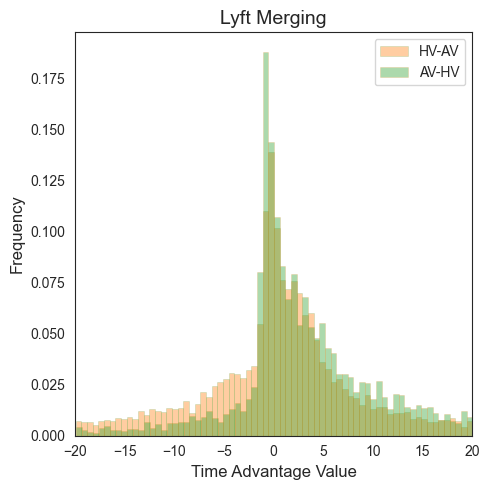

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns


TA_MIN = -20
TA_MAX = 20

# Define the custom color palette
palette = {
    "HV-HV": '#257ab6',  # Blue
    "AV-HV": '#31a231',  # Green
    "HV-AV": '#ff8214',  # Orange
}

# Set the Seaborn style without grid
sns.set_style("white")  # Remove grid by using 'white' style

# Create the plot with a square aspect ratio
fig, ax = plt.subplots(figsize=(5, 5))  # Make the figure square

# Use Seaborn to plot the histograms with custom colors
sns.histplot(
    HVAV_TAs_merge1,
    bins=70,
    stat="density",  # Use 'density' for frequency normalization
    kde=False,       # Add kernel density estimate if needed
    color=palette["HV-AV"],  # Use the custom color from the palette
    alpha=0.4,
    label='HV-AV',
    edgecolor=(49/255, 162/255, 49/255, 0.3)  # Match edge color with the fill color with transparency
)

sns.histplot(
    AVHV_TAs_merge1,
    bins=70,
    stat="density",  # Use 'density' for frequency normalization
    kde=False,       # Add kernel density estimate if needed
    color=palette["AV-HV"],  # Use another custom color from the palette
    alpha=0.4,
    label='AV-HV',
    edgecolor=(255/255, 130/255, 20/255, 0.3)  # Match edge color with the fill color with transparency
)

# Customize the plot
ax.set_title("Lyft Merging", fontsize=14)
ax.set_xlabel("Time Advantage Value", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_xlim([TA_MIN, TA_MAX])

# Add a legend
ax.legend(loc='upper right', fontsize=10)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

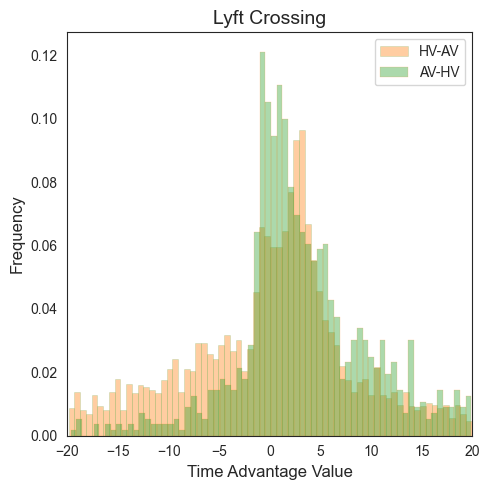

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns


TA_MIN = -20
TA_MAX = 20

# Define the custom color palette
palette = {
    "HV-HV": '#257ab6',  # Blue
    "AV-HV": '#31a231',  # Green
    "HV-AV": '#ff8214',  # Orange
}

# Set the Seaborn style without grid
sns.set_style("white")  # Remove grid by using 'white' style

# Create the plot with a square aspect ratio
fig, ax = plt.subplots(figsize=(5, 5))  # Make the figure square

# Use Seaborn to plot the histograms with custom colors
sns.histplot(
    HVAV_TAs_cross1,
    bins=70,
    stat="density",  # Use 'density' for frequency normalization
    kde=False,       # Add kernel density estimate if needed
    color=palette["HV-AV"],  # Use the custom color from the palette
    alpha=0.4,
    label='HV-AV',
    edgecolor=(49/255, 162/255, 49/255, 0.3)  # Match edge color with the fill color with transparency
)

sns.histplot(
    AVHV_TAs_cross1,
    bins=70,
    stat="density",  # Use 'density' for frequency normalization
    kde=False,       # Add kernel density estimate if needed
    color=palette["AV-HV"],  # Use another custom color from the palette
    alpha=0.4,
    label='AV-HV',
    edgecolor=(255/255, 130/255, 20/255, 0.3)  # Match edge color with the fill color with transparency
)

# Customize the plot
ax.set_title("Lyft Crossing", fontsize=14)
ax.set_xlabel("Time Advantage Value", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_xlim([TA_MIN, TA_MAX])

# Add a legend
ax.legend(loc='upper right', fontsize=10)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [26]:
import pandas as pd
from scipy.stats import ks_2samp, anderson_ksamp

# Extract the column 'TA' from each DataFrame for comparison
hvav_merge_values = HVAV_TAs_merge1
avhv_merge_values = AVHV_TAs_merge1
hvav_cross_values = HVAV_TAs_cross1
avhv_cross_values = AVHV_TAs_cross1

# Kolmogorov-Smirnov Test for Merge
ks_statistic_merge, ks_p_value_merge = ks_2samp(hvav_merge_values, avhv_merge_values)
print("Kolmogorov-Smirnov Test for Merge:")
print(f"Statistic: {ks_statistic_merge:.3f}, p-value: {ks_p_value_merge:.3f}")

# Anderson-Darling Test for Merge
ad_result_merge = anderson_ksamp([hvav_merge_values, avhv_merge_values])
print("Anderson-Darling Test for Merge:")
print(f"Statistic: {ad_result_merge.statistic:.3f}, p-value: {ad_result_merge.significance_level:.3f}")

# Kolmogorov-Smirnov Test for Cross
ks_statistic_cross, ks_p_value_cross = ks_2samp(hvav_cross_values, avhv_cross_values)
print("Kolmogorov-Smirnov Test for Cross:")
print(f"Statistic: {ks_statistic_cross:.3f}, p-value: {ks_p_value_cross:.3f}")

# Anderson-Darling Test for Cross
ad_result_cross = anderson_ksamp([hvav_cross_values, avhv_cross_values])
print("Anderson-Darling Test for Cross:")
print(f"Statistic: {ad_result_cross.statistic:.3f}, p-value: {ad_result_cross.significance_level:.3f}")

# Interpret the results
alpha = 0.05  # significance level
print("\nInterpretation:")
if ks_p_value_merge < alpha:
    print("Kolmogorov-Smirnov Test (Merge): Distributions are significantly different.")
else:
    print("Kolmogorov-Smirnov Test (Merge): Distributions are not significantly different.")

if ad_result_merge.significance_level < alpha:
    print("Anderson-Darling Test (Merge): Distributions are significantly different.")
else:
    print("Anderson-Darling Test (Merge): Distributions are not significantly different.")

if ks_p_value_cross < alpha:
    print("Kolmogorov-Smirnov Test (Cross): Distributions are significantly different.")
else:
    print("Kolmogorov-Smirnov Test (Cross): Distributions are not significantly different.")

if ad_result_cross.significance_level < alpha:
    print("Anderson-Darling Test (Cross): Distributions are significantly different.")
else:
    print("Anderson-Darling Test (Cross): Distributions are not significantly different.")

Kolmogorov-Smirnov Test for Merge:
Statistic: 0.157, p-value: 0.000
Anderson-Darling Test for Merge:
Statistic: 182.357, p-value: 0.001
Kolmogorov-Smirnov Test for Cross:
Statistic: 0.208, p-value: 0.000
Anderson-Darling Test for Cross:
Statistic: 73.904, p-value: 0.001

Interpretation:
Kolmogorov-Smirnov Test (Merge): Distributions are significantly different.
Anderson-Darling Test (Merge): Distributions are significantly different.
Kolmogorov-Smirnov Test (Cross): Distributions are significantly different.
Anderson-Darling Test (Cross): Distributions are significantly different.


C:\Users\Gavin\AppData\Local\Temp\ipykernel_22652\3267572081.py:16: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result_merge = anderson_ksamp([hvav_merge_values, avhv_merge_values])
C:\Users\Gavin\AppData\Local\Temp\ipykernel_22652\3267572081.py:26: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result_cross = anderson_ksamp([hvav_cross_values, avhv_cross_values])


## Combined

In [11]:
HVAV_TAs_cross = np.concatenate([HVAV_TAs_cross1, HVAV_TAs_cross2])
AVHV_TAs_cross = np.concatenate([AVHV_TAs_cross1, AVHV_TAs_cross2])

HVAV_TAs_merge = np.concatenate([HVAV_TAs_merge1, HVAV_TAs_merge2])
AVHV_TAs_merge = np.concatenate([AVHV_TAs_merge1, AVHV_TAs_merge2])

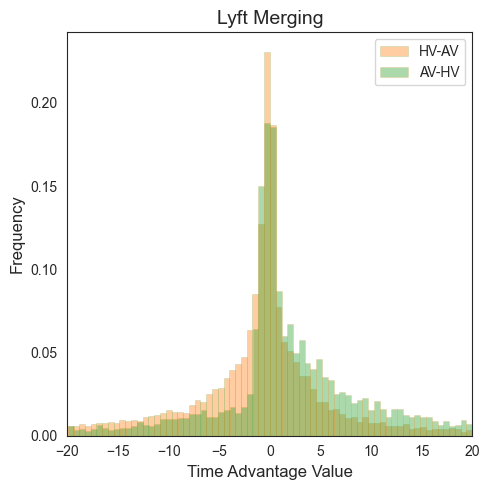

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns


TA_MIN = -20
TA_MAX = 20

# Define the custom color palette
palette = {
    "HV-HV": '#257ab6',  # Blue
    "AV-HV": '#31a231',  # Green
    "HV-AV": '#ff8214',  # Orange
}

# Set the Seaborn style without grid
sns.set_style("white")  # Remove grid by using 'white' style

# Create the plot with a square aspect ratio
fig, ax = plt.subplots(figsize=(5, 5))  # Make the figure square

# Use Seaborn to plot the histograms with custom colors
sns.histplot(
    HVAV_TAs_merge,
    bins=70,
    stat="density",  # Use 'density' for frequency normalization
    kde=False,       # Add kernel density estimate if needed
    color=palette["HV-AV"],  # Use the custom color from the palette
    alpha=0.4,
    label='HV-AV',
    edgecolor=(49/255, 162/255, 49/255, 0.3)  # Match edge color with the fill color with transparency
)

sns.histplot(
    AVHV_TAs_merge,
    bins=70,
    stat="density",  # Use 'density' for frequency normalization
    kde=False,       # Add kernel density estimate if needed
    color=palette["AV-HV"],  # Use another custom color from the palette
    alpha=0.4,
    label='AV-HV',
    edgecolor=(255/255, 130/255, 20/255, 0.3)  # Match edge color with the fill color with transparency
)

# Customize the plot
ax.set_title("Lyft Merging", fontsize=14)
ax.set_xlabel("Time Advantage Value", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_xlim([TA_MIN, TA_MAX])

# Add a legend
ax.legend(loc='upper right', fontsize=10)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

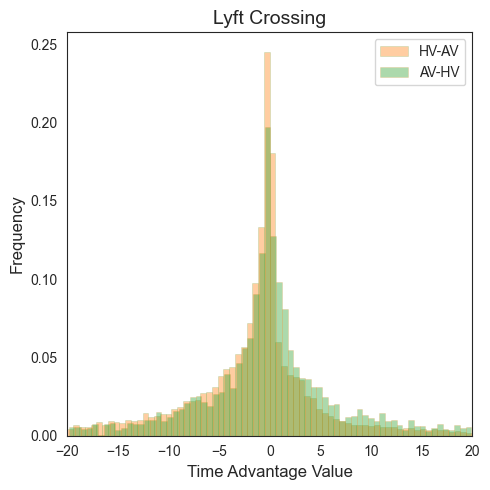

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


TA_MIN = -20
TA_MAX = 20

# Define the custom color palette
palette = {
    "HV-HV": '#257ab6',  # Blue
    "AV-HV": '#31a231',  # Green
    "HV-AV": '#ff8214',  # Orange
}

# Set the Seaborn style without grid
sns.set_style("white")  # Remove grid by using 'white' style

# Create the plot with a square aspect ratio
fig, ax = plt.subplots(figsize=(5, 5))  # Make the figure square

# Use Seaborn to plot the histograms with custom colors
sns.histplot(
    HVAV_TAs_cross,
    bins=70,
    stat="density",  # Use 'density' for frequency normalization
    kde=False,       # Add kernel density estimate if needed
    color=palette["HV-AV"],  # Use the custom color from the palette
    alpha=0.4,
    label='HV-AV',
    edgecolor=(49/255, 162/255, 49/255, 0.3)  # Match edge color with the fill color with transparency
)

sns.histplot(
    AVHV_TAs_cross,
    bins=70,
    stat="density",  # Use 'density' for frequency normalization
    kde=False,       # Add kernel density estimate if needed
    color=palette["AV-HV"],  # Use another custom color from the palette
    alpha=0.4,
    label='AV-HV',
    edgecolor=(255/255, 130/255, 20/255, 0.3)  # Match edge color with the fill color with transparency
)

# Customize the plot
ax.set_title("Lyft Crossing", fontsize=14)
ax.set_xlabel("Time Advantage Value", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_xlim([TA_MIN, TA_MAX])

# Add a legend
ax.legend(loc='upper right', fontsize=10)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()
# plt.savefig